In [1]:
import copy
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import random

import mylibrary.datasets as datasets
import mylibrary.nnlib as tnn

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [3]:
def _get_hidden_neuron_number(i, o):
    return (max(i,o)*(min(i,o)**2))**(1/3)


class Shortcut_Conv(nn.Module):

    def __init__(self, tree, input_dim, output_dim, kernel=(3,3), stride=1):
        super().__init__()
        self.tree = tree
        self._kernel = np.array(kernel, dtype=int)
        self._padding = tuple(((self._kernel-1)/2).astype(int))
        self._stride = stride
        _wd = nn.Conv2d(input_dim, output_dim, self._kernel, stride=self._stride,
                        padding=self._padding, bias=False).weight.data
        ## Shape = OutputDim, InputDim, Kernel0, Kernel1
        self.weight = nn.Parameter(
            torch.empty_like(_wd).copy_(_wd)
        )
        del _wd
    
        ## for removing and freezing neurons
        self.to_remove = None
        self.to_freeze = None
        self.initial_remove = None
        self.initial_freeze = None
    
    def forward(self, x):
        if x.shape[1] > 0 and self.weight.shape[0] > 0:
            return F.conv2d(x, self.weight, stride=self._stride, padding=self._padding)
        ### output dim is 0
        elif self.weight.shape[0] == 0:
            ###             #num_inp  #inp_dim    #feature
            x = torch.zeros(x.shape[0], 1, x.shape[2], x.shape[3], dtype=x.dtype, device=x.device)
            ###       #out_dim #inp_dim            #kernel
            w = torch.zeros(1, 1, self.weight.shape[2], self.weight.shape[3], dtype=x.dtype, device=x.device)
            o = F.conv2d(x, w, stride=self._stride, padding=self._padding)
            return torch.zeros(o.shape[0], 0, o.shape[2], o.shape[3], dtype=x.dtype, device=x.device)
        ### input dim is 0
        elif x.shape[1] == 0:
            ###             #num_inp  #inp_dim    #feature
            x = torch.zeros(x.shape[0], 1, x.shape[2], x.shape[3], dtype=x.dtype, device=x.device)
            ###             #out_dim            #inp_dim            #kernel
            w = torch.zeros(self.weight.shape[0], 1, self.weight.shape[2], self.weight.shape[3], dtype=x.dtype, device=x.device)
            o = F.conv2d(x, w, stride=self._stride, padding=self._padding)
            return o.data
        else:
            raise(f"Unknown shape of input {x.shape} or weight {self.weight.shape}")

#     def decay_std_ratio(self, factor):
#         self.weight.data = self.weight.data - self.tree.decay_rate_std*factor.t()*self.weight.data
        
#     def decay_std_ratio_grad(self, factor):
#         self.weight.grad = self.weight.grad + self.tree.decay_rate_std*factor.t()*self.weight.data
        
    def start_decaying_connection(self, to_remove):
        self.initial_remove = self.weight.data[:, to_remove]
        self.to_remove = to_remove
        self.tree.decay_connection_shortcut.add(self)
        pass
    
    def start_freezing_connection(self, to_freeze):
        self.initial_freeze = self.weight.data[to_freeze, :]
        self.to_freeze = to_freeze
        self.tree.freeze_connection_shortcut.add(self)
        pass
    
    def freeze_connection_step(self):#, to_freeze):
        self.weight.data[self.to_freeze, :] = self.initial_freeze
        pass
    
    def decay_connection_step(self):#, to_remove):
        self.weight.data[:, self.to_remove] = self.initial_remove*self.tree.decay_factor
        pass
            
     
    def remove_freezed_connection(self, remaining):
        # print(self.weight.data.shape, "removing freezed; ", self.to_freeze)
        _w = self.weight.data[remaining, :]
        del self.weight
        self.weight = nn.Parameter(_w)
        self.initial_freeze = None
        self.to_freeze = None
        pass
    
    def remove_decayed_connection(self, remaining):
        # print(self.weight.data.shape, "removing decayed; ", self.to_remove)
        _w = self.weight.data[:, remaining]
        del self.weight
        self.weight = nn.Parameter(_w)
        self.initial_remove = None
        self.to_remove = None
        pass
    
    def add_input_connection(self, num):
        # print(self.weight.data.shape)
        o, i, k0, k1 = self.weight.data.shape
        _w = torch.cat((self.weight.data, torch.zeros(o, num, k0, k1, dtype=self.weight.data.dtype,
                                                      device=self.weight.data.device)), dim=1)
        del self.weight
        self.weight = nn.Parameter(_w)
        # print(self.weight.data.shape)
        pass

    def add_output_connection(self, num):
        # print(self.weight.data.shape)
        o, i, k0, k1 = self.weight.data.shape
        stdv = 1. / np.sqrt(i)
        _new = torch.empty(num, i, k0, k1, dtype=self.weight.data.dtype,
                           device=self.weight.data.device).uniform_(-stdv, stdv)
        
        _w = torch.cat((self.weight.data, _new), dim=0)
        del self.weight
        self.weight = nn.Parameter(_w)
        # print(self.weight.data.shape)        
        pass
    
    def print_network_debug(self, depth):
        print(f"{'║     '*depth}S▚:{depth}[{self.weight.data.shape[1]},{self.weight.data.shape[0]}]")



In [4]:
sc = Shortcut_Conv("tree", 1, 5)

In [5]:
sc.weight.shape

torch.Size([5, 1, 3, 3])

In [6]:
inp = torch.randn(1, 1, 28,28)

In [7]:
inp.shape

torch.Size([1, 1, 28, 28])

In [8]:
# sc(inp).shape

In [9]:
conv = nn.Conv2d(1, 5, (3,3), padding=(1,1), bias=False)

In [10]:
conv.weight.shape

torch.Size([5, 1, 3, 3])

In [11]:
conv(inp).shape

torch.Size([1, 5, 28, 28])

In [12]:
F.conv2d(inp, sc.weight, stride = sc._stride, padding=sc._padding).shape

torch.Size([1, 5, 28, 28])

In [13]:
w = torch.randn(5,1,3,3)

In [14]:
b = torch.randn(5)

In [15]:
i = torch.randn(1, 1, 2,2)

In [16]:
F.conv2d(i, w, stride = sc._stride, padding=sc._padding) + b.view(1,-1,1,1)

tensor([[[[ 4.1030, -0.6012],
          [ 0.6821, -4.1699]],

         [[-0.2095,  1.1301],
          [ 3.2032,  5.9024]],

         [[-2.8604,  4.0165],
          [ 2.1841, -0.5844]],

         [[-1.4028,  2.4924],
          [ 0.2415, -4.3600]],

         [[-4.4734, -4.0532],
          [ 1.0835,  2.7726]]]])

In [17]:
torch.zeros(1, 0, 28,28)

tensor([], size=(1, 0, 28, 28))

In [18]:
w = torch.randn(5,2,3,3)

In [19]:
w.shape

torch.Size([5, 2, 3, 3])

In [20]:
w[:, [1], :, :].shape

torch.Size([5, 1, 3, 3])

In [21]:
w_ = np.random.randn(5,2,3,3)

In [22]:
# w_[[0,1,2], [0,1], :, :].shape

In [23]:
class NonLinearity_Conv(nn.Module):

    def __init__(self, tree, io_dim, actf_obj=nn.ReLU()):
        super().__init__()
        self.tree = tree
        self.bias = nn.Parameter(torch.zeros(io_dim))
        self.actf = actf_obj

    def forward(self, x):
        return self.actf(x+self.bias.view(1,-1,1,1))

    def add_neuron(self, num):
        _b = torch.cat((self.bias.data, torch.zeros(num, dtype=self.bias.data.dtype,
                                                    device=self.bias.data.device)))
        del self.bias
        self.bias = nn.Parameter(_b)
        
    def remove_neuron(self, remaining):
        _b = self.bias.data[remaining]
        del self.bias
        self.bias = nn.Parameter(_b)

In [24]:
class NonLinearity(nn.Module):

    def __init__(self, tree, io_dim, actf_obj=nn.ReLU()):
        super().__init__()
        self.tree = tree
        self.bias = nn.Parameter(torch.zeros(io_dim))
        self.actf = actf_obj

    def forward(self, x):
        return self.actf(x+self.bias)

    def add_neuron(self, num):
        _b = torch.cat((self.bias.data, torch.zeros(num, dtype=self.bias.data.dtype,
                                                    device=self.bias.data.device)))
        del self.bias
        self.bias = nn.Parameter(_b)
        
    def remove_neuron(self, remaining):
        _b = self.bias.data[remaining]
        del self.bias
        self.bias = nn.Parameter(_b)

In [25]:
conv = nn.Conv2d(1, 5, (3,3), padding=(1,1))

In [26]:
conv.bias

Parameter containing:
tensor([-0.2322,  0.1578,  0.1843,  0.1363,  0.3134], requires_grad=True)

In [27]:
class Residual_Conv(nn.Module):

    def __init__(self, tree, input_dim, hidden_dim, output_dim, stride=1):
        super().__init__()
        self.tree = tree
        self.hidden_dim = hidden_dim
#         self.stride = stride
        self.del_neurons = 0.
        self.neurons_added = 0

        ## Shortcut or Hierarchical Residual Layer
        self.fc0 = HierarchicalResidual_Conv(self.tree, input_dim, hidden_dim, stride=stride) 
        self.non_linearity = NonLinearity_Conv(self.tree, hidden_dim)
        self.fc1 = HierarchicalResidual_Conv(self.tree, hidden_dim, output_dim)
        self.fc1.shortcut.weight.data *= 0.
        
        self.tree.parent_dict[self.fc0] = self
        self.tree.parent_dict[self.fc1] = self
        self.tree.parent_dict[self.non_linearity] = self
        
        self.hook = None
        self.activations = None
        self.significance = None
        self.count = None
        self.apnz = None
        self.to_remove = None
    
    def forward(self, x):
        x = self.fc0(x)
        x = self.non_linearity(x)
        self.activations = x.data
        x = self.fc1(x)
        return x
    
    def start_computing_significance(self):
        self.significance = 0.
        self.count = 0
        self.apnz = 0
        self.hook = self.non_linearity.register_backward_hook(self.compute_neuron_significance)
        pass
            
    def finish_computing_significance(self):
        self.hook.remove()
        self.significance = self.significance#/self.count
        self.apnz = self.apnz/self.count
#         print(f"Significance before rethinking(apnz)\n{self.significance}")
#         print(f"Apnz\n{self.apnz}")
        self.significance = self.significance*(1-self.apnz) * 4 ## tried on desmos.
#         print(f"Significance after rethinking(apnz)\n{self.significance}")
        self.count = None
        self.hook = None
        pass
    
    def compute_neuron_significance(self, _class, grad_input, grad_output):
        with torch.no_grad():
            z = torch.sum(grad_output[0].data*self.activations, dim=(2,3))
            self.significance += z.pow(2).sum(dim=0)
            self.count += grad_output[0].shape[0]*grad_output[0].shape[2]*grad_output[0].shape[3]
    #         self.apnz += torch.count_nonzero(self.activations.data, dim=0)
            self.apnz += torch.sum(self.activations > 0., dim=(0,2,3), dtype=z.dtype).to(z.device)
        pass
    
    def identify_removable_neurons(self, below):
        if self.to_remove is not None:
            print("First remove all previous less significant neurons")
            return
        
        self.to_remove = torch.nonzero(self.significance<=below).reshape(-1)
        if len(self.to_remove)>0:
            self.fc0.start_freezing_connection(self.to_remove)
            self.fc1.start_decaying_connection(self.to_remove)
            self.tree.remove_neuron_residual.add(self)
            return len(self.to_remove)
        
        self.to_remove = None
        return 0

    def remove_decayed_neurons(self):
        remaining = []
        for i in range(self.hidden_dim):
            if i not in self.to_remove:
                remaining.append(i)
        
        self.non_linearity.remove_neuron(remaining)
        self.fc0.remove_freezed_connection(remaining)
        self.fc1.remove_decayed_connection(remaining)
        
        self.neurons_added -= len(self.to_remove)
        self.hidden_dim = len(remaining)
        self.to_remove = None
        pass
    
    def compute_del_neurons(self):
        self.del_neurons = (1-self.tree.beta_del_neuron)*self.neurons_added \
                            + self.tree.beta_del_neuron*self.del_neurons
        self.neurons_added = 0
        return
    
    def add_hidden_neuron(self, num):
        self.fc0.add_output_connection(num)
        self.non_linearity.add_neuron(num)
        self.fc1.add_input_connection(num)
        
        self.hidden_dim += num
        self.neurons_added += num
        pass

    def morph_network(self):
        self.fc0.morph_network()
        self.fc1.morph_network()
#         max_dim = np.ceil((self.tree.parent_dict[self].input_dim+\
#             self.tree.parent_dict[self].output_dim)/2)
        max_dim = _get_hidden_neuron_number(self.tree.parent_dict[self].input_dim,
            self.tree.parent_dict[self].output_dim)+1
        if self.hidden_dim <= max_dim:
            if self.fc0.residual is None:
                if self.fc0 in self.tree.DYNAMIC_LIST:
                    self.tree.DYNAMIC_LIST.remove(self.fc0)
            if self.fc1.residual is None:
                if self.fc1 in self.tree.DYNAMIC_LIST:
                    self.tree.DYNAMIC_LIST.remove(self.fc1)
        return 

    def print_network_debug(self, depth):
        print(f"{'║     '*depth}R▚:{depth}[{self.hidden_dim}|{self.non_linearity.bias.data.shape[0]}]")
        self.fc0.print_network_debug(depth+1)
        self.fc1.print_network_debug(depth+1)
        
    def print_network(self, pre_string):
        self.fc0.print_network(pre_string)
        print(f"{pre_string}{self.hidden_dim}")
        self.fc1.print_network(pre_string)
        return

In [28]:
class HierarchicalResidual_Conv(nn.Module):

    def __init__(self, tree, input_dim, output_dim, stride=1):
        super().__init__()

        self.tree = tree
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.stride = 1
        
        ## this can be Shortcut Layer or None
        self.shortcut = Shortcut_Conv(tree, self.input_dim, self.output_dim, stride=self.stride).to(self.tree.device)
        self.tree.parent_dict[self.shortcut] = self
        
        self.residual = None ## this can be Residual Layer or None
        ##### only one of shortcut or residual can be None at a time
        self.forward = self.forward_shortcut
        
        self.std_ratio = 0. ## 0-> all variation due to shortcut, 1-> residual
        self.target_std_ratio = 0. ##
    
    def forward_both(self, r):
        s = self.shortcut(r)
        r = self.residual(r)

        if self.residual.hook is None: ### dont execute when computing significance
            s_std = torch.std(s, dim=(0,2,3), keepdim=True).reshape(1, -1)
            r_std = torch.std(r, dim=(0,2,3), keepdim=True).reshape(1, -1)
            stdr = r_std/(s_std+r_std)

            self.std_ratio = self.tree.beta_std_ratio*self.std_ratio + (1-self.tree.beta_std_ratio)*stdr.data
            if r_std.min() > 1e-9:
                ## recover for the fact that when decaying neurons, target ratio should also be reducing
                if self.tree.total_decay_steps:
                    i, o = self.shortcut.weight.shape[1],self.shortcut.weight.shape[0]
                    if self.shortcut.to_remove is not None:
                        i -= len(self.shortcut.to_remove)
                    if self.shortcut.to_freeze is not None:
                        o -= len(self.shortcut.to_freeze)
                    h = self.residual.hidden_dim
                    if self.residual.to_remove is not None:
                        h -= len(self.residual.to_remove)
                    
#                     tr = h/np.ceil((i+o)/2 +1)
                    tr = h/_get_hidden_neuron_number(i, o)
                    self.compute_target_std_ratio(tr)
                else:
                    self.compute_target_std_ratio()
                self.get_std_loss(stdr)
        return s+r
    
    def forward_shortcut(self, x):
        return self.shortcut(x)
    
    def forward_residual(self, x):
        self.compute_target_std_ratio()
        return self.residual(x)
    
    def compute_target_std_ratio(self, tr = None):
        if tr is None:
#             tr = self.residual.hidden_dim/np.ceil((self.input_dim+self.output_dim)/2 +1)
            tr = self.residual.hidden_dim/_get_hidden_neuron_number(self.input_dim, self.output_dim)
#             tr = self.residual.hidden_dim/np.ceil(self.output_dim/2 +1)

        tr = np.clip(tr, 0., 1.)
        self.target_std_ratio = self.tree.beta_std_ratio*self.target_std_ratio +\
                                (1-self.tree.beta_std_ratio)*tr
        pass        
    
    def get_std_loss(self, stdr):
        del_std = self.target_std_ratio-stdr
        del_std_loss = (del_std**2 + torch.abs(del_std)).mean()
#         del_std_loss = (del_std**2).mean()
        self.tree.std_loss += del_std_loss
        return
            
    def start_freezing_connection(self, to_freeze):
        if self.shortcut:
            self.shortcut.start_freezing_connection(to_freeze)
        if self.residual:
            self.residual.fc1.start_freezing_connection(to_freeze)
        pass
        
    def start_decaying_connection(self, to_remove):
        if self.shortcut:
            self.shortcut.start_decaying_connection(to_remove)
        if self.residual:
            self.residual.fc0.start_decaying_connection(to_remove)
        pass
    
    def remove_freezed_connection(self, remaining):
        if self.shortcut:
            self.shortcut.remove_freezed_connection(remaining)
        if self.residual:
            self.residual.fc1.remove_freezed_connection(remaining)
            if self.shortcut: self.std_ratio = self.std_ratio[:, remaining]
        self.output_dim = len(remaining)
        pass
    
    def remove_decayed_connection(self, remaining):
        if self.shortcut:
            self.shortcut.remove_decayed_connection(remaining)
        if self.residual:
            self.residual.fc0.remove_decayed_connection(remaining)
        self.input_dim = len(remaining)
        pass
    
    def add_input_connection(self, num):
        self.input_dim += num
        if self.shortcut:
            self.shortcut.add_input_connection(num)
        if self.residual:
            self.residual.fc0.add_input_connection(num)

    def add_output_connection(self, num):
        self.output_dim += num
        if self.shortcut:
            self.shortcut.add_output_connection(num)
        if self.residual:
            self.residual.fc1.add_output_connection(num)
            # if torch.is_tensor(self.std_ratio):
            if self.shortcut:
                self.std_ratio = torch.cat((self.std_ratio, torch.zeros(1, num, device=self.tree.device)), dim=1)

    def add_hidden_neuron(self, num):
        if num<1: return
        
        if self.residual is None:
            # print(f"Adding {num} hidden units.. in new residual_layer")
            self.residual = Residual_Conv(self.tree, self.input_dim,
                                          num, self.output_dim, stride=self.stride).to(self.tree.device)
            
            self.tree.parent_dict[self.residual] = self
            if self.shortcut is None:
                self.forward = self.forward_residual
                self.std_ratio = 1.
            else:
                self.forward = self.forward_both
                self.std_ratio = torch.zeros(1, self.output_dim, device=self.tree.device)
                
        else:
            # print(f"Adding {num} hidden units..")
            self.residual.add_hidden_neuron(num)
        return
    
    def maintain_shortcut_connection(self):
        if self.residual is None: return
        
        if self.shortcut:
            if self.std_ratio.min()>0.98 and self.target_std_ratio>0.98:
                del self.tree.parent_dict[self.shortcut]
                del self.shortcut
                self.shortcut = None
                self.forward = self.forward_residual
                self.std_ratio = 1.
            
        elif self.target_std_ratio<0.95:
            self.shortcut = Shortcut_Conv(self.tree, self.input_dim, self.output_dim, stride=self.stride)
            self.shortcut.weight.data *= 0.
            self.forward = self.forward_both
            
        self.residual.fc0.maintain_shortcut_connection()
        self.residual.fc1.maintain_shortcut_connection()
        
    def morph_network(self):
        if self.residual is None: return
        
        if self.residual.hidden_dim < 1:
            del self.tree.parent_dict[self.residual]
            del self.residual
            ### its parent (Residual_Conv) removes it from dynamic list if possible
            self.residual = None
            self.forward = self.forward_shortcut
            self.std_ratio = 0.
            return
        
#         max_dim = np.ceil((self.input_dim+self.output_dim)/2)
        # max_dim = min((self.input_dim, self.output_dim))+1
        max_dim = _get_hidden_neuron_number(self.input_dim, self.output_dim) + 1 
        # print("MaxDIM", max_dim, self.residual.hidden_dim)
        if self.residual.hidden_dim > max_dim:
            self.tree.DYNAMIC_LIST.add(self.residual.fc0)
            self.tree.DYNAMIC_LIST.add(self.residual.fc1)
            # print("Added", self.residual)
            
        # self.residual.fc0.morph_network()
        # self.residual.fc1.morph_network()
        self.residual.morph_network()
        
    def print_network_debug(self, depth):
        stdr = self.std_ratio
        if torch.is_tensor(self.std_ratio):
            stdr = self.std_ratio.min()
            
        print(f"{'|     '*depth}H:{depth}[{self.input_dim},{self.output_dim}]"+\
              f"σ[t:{self.target_std_ratio}, s:{stdr}")
        if self.shortcut:
            self.shortcut.print_network_debug(depth+1)
        if self.residual:
            self.residual.print_network_debug(depth+1)
        pass
    
    def print_network(self, pre_string=""):
        if self.residual is None:
            return
        
        if self.shortcut:
            print(f"{pre_string}╠════╗")
            self.residual.print_network(f"{pre_string}║    ")
            print(f"{pre_string}╠════╝")
        else:
            print(f"{pre_string}╚════╗")
            self.residual.print_network(f"{pre_string}     ")
            print(f"{pre_string}╔════╝")
        return

### Conv Conv Connector

In [29]:
class Residual_Conv_Connector(nn.Module):

    def __init__(self, tree, hrnet0, hrnet1, activation, hidden_dim, post_activation=None):
        super().__init__()
        self.tree = tree
        self.hidden_dim = hidden_dim
        self.del_neurons = 0.
        self.neurons_added = 0
        self.post_activation = post_activation

        ## Shortcut or Hierarchical Residual Layer
        self.fc0 = hrnet0
        self.non_linearity = NonLinearity_Conv(self.tree, hidden_dim, activation)
        self.fc1 = hrnet1
        
        self.tree.parent_dict[self.fc0] = self
        self.tree.parent_dict[self.fc1] = self
        self.tree.parent_dict[self.non_linearity] = self
        
        self.hook = None
        self.activations = None
        self.significance = None
        self.count = None
        self.apnz = None
        self.to_remove = None
    
    def forward(self, x):
        x = self.fc0(x)
        x = self.non_linearity(x)
        self.activations = x.data
        if self.post_activation:
            x = self.post_activation(x)
        x = self.fc1(x)
        return x
    
    def start_computing_significance(self):
        self.significance = 0.
        self.count = 0
        self.apnz = 0
        self.hook = self.non_linearity.register_backward_hook(self.compute_neuron_significance)
        pass
            
    def finish_computing_significance(self):
        self.hook.remove()
        self.significance = self.significance#/self.count
        self.apnz = self.apnz/self.count
#         print(f"Significance before rethinking(apnz)\n{self.significance}")
#         print(f"Apnz\n{self.apnz}")
        self.significance = self.significance*(1-self.apnz) * 4 ## tried on desmos.
#         print(f"Significance after rethinking(apnz)\n{self.significance}")
        self.count = None
        self.hook = None
        pass
    
    def compute_neuron_significance(self, _class, grad_input, grad_output):
        with torch.no_grad():
            z = torch.sum(grad_output[0].data*self.activations, dim=(2,3))
            self.significance += z.pow(2).sum(dim=0)
            self.count += grad_output[0].shape[0]*grad_output[0].shape[2]*grad_output[0].shape[3]
    #         self.apnz += torch.count_nonzero(self.activations.data, dim=0)
            self.apnz += torch.sum(self.activations > 0., dim=(0,2,3), dtype=z.dtype).to(z.device)
        pass
    
    def identify_removable_neurons(self, below):
        if self.to_remove is not None:
            print("First remove all previous less significant neurons")
            return
        
        self.to_remove = torch.nonzero(self.significance<=below).reshape(-1)
        if len(self.to_remove)>0:
            self.fc0.start_freezing_connection(self.to_remove)
            self.fc1.start_decaying_connection(self.to_remove)
            self.tree.remove_neuron_residual.add(self)
            return len(self.to_remove)
        
        self.to_remove = None
        return 0

    def remove_decayed_neurons(self):
        remaining = []
        for i in range(self.hidden_dim):
            if i not in self.to_remove:
                remaining.append(i)
        
        self.non_linearity.remove_neuron(remaining)
        self.fc0.remove_freezed_connection(remaining)
        self.fc1.remove_decayed_connection(remaining)
        
        self.neurons_added -= len(self.to_remove)
        self.hidden_dim = len(remaining)
        self.to_remove = None
        pass
    
    def compute_del_neurons(self):
        self.del_neurons = (1-self.tree.beta_del_neuron)*self.neurons_added \
                            + self.tree.beta_del_neuron*self.del_neurons
        self.neurons_added = 0
        return
    
    def add_hidden_neuron(self, num):
        self.fc0.add_output_connection(num)
        self.non_linearity.add_neuron(num)
        self.fc1.add_input_connection(num)
        
        self.hidden_dim += num
        self.neurons_added += num
        pass

    def morph_network(self):
        self.fc0.morph_network()
        self.fc1.morph_network()
        max_dim = _get_hidden_neuron_number(self.tree.parent_dict[self].input_dim,
            self.tree.parent_dict[self].output_dim)+1
        if self.hidden_dim <= max_dim:
            if self.fc0.residual is None:
                if self.fc0 in self.tree.DYNAMIC_LIST:
                    self.tree.DYNAMIC_LIST.remove(self.fc0)
            if self.fc1.residual is None:
                if self.fc1 in self.tree.DYNAMIC_LIST:
                    self.tree.DYNAMIC_LIST.remove(self.fc1)
        return 

    def print_network_debug(self, depth):
        print(f"{'║     '*depth}R▚:{depth}[{self.hidden_dim}|{self.non_linearity.bias.data.shape[0]}]")
        self.fc0.print_network_debug(depth+1)
        self.fc1.print_network_debug(depth+1)
        
    def print_network(self, pre_string):
        self.fc0.print_network(pre_string)
        print(f"{pre_string}{self.hidden_dim}")
        self.fc1.print_network(pre_string)
        return

In [30]:
class HierarchicalResidual_Connector(nn.Module):

    def __init__(self, tree, hrnet0, hrnet1, activation=nn.ReLU(), post_activation=None):
        super().__init__()

        self.tree = tree
        self.input_dim = hrnet0.input_dim
        self.output_dim = hrnet1.output_dim
        
        ## this can be Shortcut Layer or None
        self.shortcut = None
        self.residual = Residual_Conv_Connector(self.tree, hrnet0, hrnet1,
                                                activation, hrnet0.output_dim, post_activation)
        self.tree.parent_dict[self.residual] = self
            
    
    def forward(self, x):
        return self.residual(x)
    
    def start_freezing_connection(self, to_freeze):
        self.residual.fc1.start_freezing_connection(to_freeze)
        pass
        
    def start_decaying_connection(self, to_remove):
        self.residual.fc0.start_decaying_connection(to_remove)
        pass
    
    def remove_freezed_connection(self, remaining):
        self.residual.fc1.remove_freezed_connection(remaining)
        self.output_dim = len(remaining)
        pass
    
    def remove_decayed_connection(self, remaining):
        self.residual.fc0.remove_decayed_connection(remaining)
        self.input_dim = len(remaining)
        pass
    
    def add_input_connection(self, num):
        self.input_dim += num
        self.residual.fc0.add_input_connection(num)

    def add_output_connection(self, num):
        self.output_dim += num
        self.residual.fc1.add_output_connection(num)
        
    def add_hidden_neuron(self, num):
        if num<1: return
        self.residual.add_hidden_neuron(num)
        return
    
    def maintain_shortcut_connection(self):  
        self.residual.fc0.maintain_shortcut_connection()
        self.residual.fc1.maintain_shortcut_connection()
        
    def morph_network(self):
        self.residual.morph_network()
        
    def print_network_debug(self, depth):
        print(f"{'|     '*depth}H:{depth}[{self.input_dim},{self.output_dim}]"+\
              f"σ[t:{None}, s:{None}")
        self.residual.print_network_debug(depth+1)
        pass
    
    def print_network(self, pre_string=""):
        print(f"{pre_string}╚╗")
        self.residual.print_network(f"{pre_string} ")
        print(f"{pre_string}╔╝")
        return

## Shortcut only Hierarchical Residual Network

In [31]:
class Shortcut(nn.Module):

    def __init__(self, tree, input_dim, output_dim):
        super().__init__()
        self.tree = tree
        _wd = nn.Linear(input_dim, output_dim, bias=False).weight.data
        self.weight = nn.Parameter(
            torch.empty_like(_wd).copy_(_wd)
        )
    
        ## for removing and freezing neurons
        self.to_remove = None
        self.to_freeze = None
        self.initial_remove = None
        self.initial_freeze = None
    
    def forward(self, x):
        ## input_dim        ## output_dim
        if x.shape[1] + self.weight.shape[1] > 0:
            return x.matmul(self.weight.t())
        else:
            # print(x.shape, self.weight.shape)
            # print(x.matmul(self.weight.t()))
            if x.shape[1] + self.weight.shape[1] == 0:
                return torch.zeros(x.shape[0], self.weight.shape[0], dtype=x.dtype, device=x.device)
        
    def start_decaying_connection(self, to_remove):
        self.initial_remove = self.weight.data[:, to_remove]
        self.to_remove = to_remove
        self.tree.decay_connection_shortcut.add(self)
        pass
    
    def start_freezing_connection(self, to_freeze):
        self.initial_freeze = self.weight.data[to_freeze, :]
        self.to_freeze = to_freeze
        self.tree.freeze_connection_shortcut.add(self)
        pass
    
    def freeze_connection_step(self):#, to_freeze):
        self.weight.data[self.to_freeze, :] = self.initial_freeze
        pass
    
    def decay_connection_step(self):#, to_remove):
        self.weight.data[:, self.to_remove] = self.initial_remove*self.tree.decay_factor
        pass
            
     
    def remove_freezed_connection(self, remaining):
        # print(self.weight.data.shape, "removing freezed; ", self.to_freeze)
        _w = self.weight.data[remaining, :]
        del self.weight
        self.weight = nn.Parameter(_w)
        self.initial_freeze = None
        self.to_freeze = None
        pass
    
    def remove_decayed_connection(self, remaining):
        # print(self.weight.data.shape, "removing decayed; ", self.to_remove)
        _w = self.weight.data[:, remaining]
        del self.weight
        self.weight = nn.Parameter(_w)
        self.initial_remove = None
        self.to_remove = None
        pass
    
    def add_input_connection(self, num):
        # print(self.weight.data.shape)
        o, i = self.weight.data.shape
        _w = torch.cat((self.weight.data, torch.zeros(o, num, dtype=self.weight.data.dtype,
                                                      device=self.weight.data.device)), dim=1)
        del self.weight
        self.weight = nn.Parameter(_w)
        # print(self.weight.data.shape)
        pass

    def add_output_connection(self, num):
        # print(self.weight.data.shape)
        o, i = self.weight.data.shape
        stdv = 1. / np.sqrt(i)
        _new = torch.empty(num, i, dtype=self.bias.weight.dtype,
                           device=self.weight.data.device).uniform_(-stdv, stdv)
        
        _w = torch.cat((self.weight.data, _new), dim=0)
        del self.weight
        self.weight = nn.Parameter(_w)
        # print(self.weight.data.shape)        
        pass
    
    def print_network_debug(self, depth):
        print(f"{'|     '*depth}S:{depth}[{self.weight.data.shape[1]},{self.weight.data.shape[0]}]")


class HierarchicalResidual_Shortcut(nn.Module):

    def __init__(self, tree, input_dim, output_dim, kernel=None, stride=1):
        super().__init__()

        self.tree = tree
        self.input_dim = input_dim
        self.output_dim = output_dim
        ## this can be Shortcut Layer or None
        if kernel is None:
            self.shortcut = Shortcut(tree, self.input_dim, self.output_dim) 
        else:
            self.shortcut = Shortcut_Conv(tree, self.input_dim, self.output_dim, kernel, stride) 
        self.tree.parent_dict[self.shortcut] = self
        
        self.residual = None
    
    def forward(self, x):
        return self.shortcut(x)
    
    def start_freezing_connection(self, to_freeze):
        self.shortcut.start_freezing_connection(to_freeze)
        
    def start_decaying_connection(self, to_remove):
        self.shortcut.start_decaying_connection(to_remove)
    
    def remove_freezed_connection(self, remaining):
        self.shortcut.remove_freezed_connection(remaining)
        self.output_dim = len(remaining)
    
    def remove_decayed_connection(self, remaining):
        self.shortcut.remove_decayed_connection(remaining)
        self.input_dim = len(remaining)
        pass
    
    def add_input_connection(self, num):
        self.input_dim += num
        self.shortcut.add_input_connection(num)

    def add_output_connection(self, num):
        self.output_dim += num
        self.shortcut.add_output_connection(num)

    def add_hidden_neuron(self, num):
        print("Cannot Add Hidden neuron to Shortcut Only Layer")
        return
    
    def maintain_shortcut_connection(self):
        pass
        
    def morph_network(self):
        pass
        
    def print_network_debug(self, depth):
        print(f"{'|     '*depth}H:{depth}[{self.input_dim},{self.output_dim}]"+\
              f"σ[t:{None}, s:{None}")
        self.shortcut.print_network_debug(depth+1)
        pass
    
    def print_network(self, pre_string=""):
        pass

# Tree and Controller

In [32]:
class Tree_State():
    
    def __init__(self):
        self.DYNAMIC_LIST = set() ## residual parent is added, to make code effecient.
        ## the parents which is not intended to have residual connection should not be added.
        self.beta_std_ratio = None
        self.beta_del_neuron = None
        self.device = 'cpu'
    
        self.parent_dict = {}
    
        self.total_decay_steps = None
        self.current_decay_step = None
        self.decay_factor = None
        self.remove_neuron_residual:set = None
        self.freeze_connection_shortcut:set = None
        self.decay_connection_shortcut:set = None

        self.decay_rate_std = 0.001

        self.add_to_remove_ratio = 2.
        pass
    
    def get_decay_factor(self):
        ratio = self.current_decay_step/self.total_decay_steps
#         self.decay_factor = np.exp(-2*ratio)*(1-ratio)
        self.decay_factor = (1-ratio)**2
        pass
    
    def clear_decay_variables(self):
        self.total_decay_steps = None
        self.current_decay_step = None
        self.decay_factor = None
        self.remove_neuron_residual = None
        self.freeze_connection_shortcut = None
        self.decay_connection_shortcut = None
        

## constructing Hierarchical Residual CNN (Resnet Inspired)

In [33]:
tree = Tree_State()
hrn0 = HierarchicalResidual_Conv(tree, 1, 8)
hrn1 = HierarchicalResidual_Conv(tree, 8, 16)
hrn2 = HierarchicalResidual_Conv(tree, 16, 32)
hrn3 = HierarchicalResidual_Conv(tree, 32, 64)

In [34]:
hrn01 = HierarchicalResidual_Connector(tree, hrn0, hrn1)
hrn012 = HierarchicalResidual_Connector(tree, hrn01, hrn2)
hrn0123 = HierarchicalResidual_Connector(tree, hrn012, hrn3)

In [35]:
hrnfc = HierarchicalResidual_Shortcut(tree, 64, 10)

In [36]:
def pool_and_reshape(x):
    x = F.adaptive_avg_pool2d(x, (1,1))
    x = x.view(x.shape[0], -1)
    return x

hrn0123fc = HierarchicalResidual_Connector(tree, hrn0123, hrnfc,
                                           activation=lambda x: x, post_activation=pool_and_reshape)

In [37]:
hrn0123fc(inp) ## worked at once.. !! :D

tensor([[-0.0102, -0.0079, -0.0129,  0.0178, -0.0268, -0.0098,  0.0014,  0.0122,
         -0.0068,  0.0120]], grad_fn=<MmBackward>)

In [38]:
inp.shape

torch.Size([1, 1, 28, 28])

In [39]:
class Dynamic_CNN(nn.Module):

    def __init__(self, device, input_dim = 1, hidden_dims = [8, 16, 32, 64], output_dim = 10, final_activation=None,
                 num_stat=5, num_std=100, decay_rate_std=0.001):
        super().__init__()
        self.tree = Tree_State()
        self.tree.beta_del_neuron = (num_stat-1)/num_stat
        self.tree.beta_std_ratio = (num_std-1)/num_std
        self.tree.decay_rate_std = decay_rate_std
        self.tree.device = device
        
        self.root_net = None
        self._construct_root_net(input_dim, hidden_dims, output_dim)
        
#         self.tree.DYNAMIC_LIST.add(self.root_net)
        self.tree.parent_dict[self.root_net] = None
        
        if final_activation is None:
            final_activation = lambda x: x
        self.non_linearity = NonLinearity("Root", output_dim, final_activation)
        
        self.neurons_added = 0

        self._remove_below = None ## temporary variable
        
    def _construct_root_net(self, input_dim, hidden_dims, output_dim):
        
        hrnR = HierarchicalResidual_Shortcut(self.tree, 1, 8, kernel=(3,3), stride=1)
        hrn0 = HierarchicalResidual_Conv(self.tree, 8, 8)
        hrn1 = HierarchicalResidual_Conv(self.tree, 8, 16, stride=2)
        hrn2 = HierarchicalResidual_Conv(self.tree, 16, 32, stride=2)
        hrn3 = HierarchicalResidual_Conv(self.tree, 32, 32, stride=2)

        hrnR0 = HierarchicalResidual_Connector(self.tree, hrnR, hrn0)
        hrnR01 = HierarchicalResidual_Connector(self.tree, hrnR0, hrn1)
        hrnR012 = HierarchicalResidual_Connector(self.tree, hrnR01, hrn2)
        hrnR0123 = HierarchicalResidual_Connector(self.tree, hrnR012, hrn3)
        hrnfc = HierarchicalResidual_Shortcut(self.tree, 32, 10)
        
        def pool_and_reshape(x):
            x = F.adaptive_avg_pool2d(x, (1,1))
            x = x.view(x.shape[0], -1)
            return x
        
#         actf = lambda x: x
        actf = nn.ReLU()
        hrnR0123fc = HierarchicalResidual_Connector(self.tree, hrnR0123, hrnfc,
                                                   activation=actf, post_activation=pool_and_reshape)
        self.root_net = hrnR0123fc
        
        ## make every hierarchical Layer Morphable
        morphables = [self.root_net, hrnR0123, hrnR012, hrnR01, hrnR0, hrn3, hrn2, hrn1, hrn0]
#         morphables = [self.root_net, hrn0123, hrn012, hrn01]
        for hr in morphables:
            self.tree.DYNAMIC_LIST.add(hr)
        return
    
    def forward(self, x):
        return self.non_linearity(self.root_net(x))

    def add_neurons(self, num):
        num_stat = num//2
        num_random = num - num_stat
        
        DL = list(self.tree.DYNAMIC_LIST)
        if num_random>0:
            rands = torch.randint(high=len(DL), size=(num_random,))
            index, count = torch.unique(rands, sorted=False, return_counts=True)
            for i, idx in enumerate(index):
                DL[idx].add_hidden_neuron(int(count[i]))

        if num_stat>0:
            del_neurons = []
            for hr in DL:
                if hr.residual:
                    del_neurons.append(hr.residual.del_neurons)#+1e-7)
                else:
                    del_neurons.append(0.)#1e-7) ## residual layer yet not created 
            
            prob_stat = torch.tensor(del_neurons)
            prob_stat = torch.log(torch.exp(prob_stat)+1.)
            m = torch.distributions.multinomial.Multinomial(total_count=num_stat,
                                                            probs= prob_stat)
            count = m.sample()#.type(torch.long)
            for i, hr in enumerate(DL):
                if count[i] < 1: continue
                hr.add_hidden_neuron(int(count[i]))
        
        self.neurons_added += num 
        pass

    def identify_removable_neurons(self, num=None, threshold_min=0., threshold_max=1.):
        
        all_sig = []
        self.all_sig_ = []
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                all_sig.append(hr.residual.significance)
        all_sigs = torch.cat(all_sig)
        del all_sig
        print("All_sigs", all_sigs)
        
        
#         print("Normalization", (all_sigs/all_sigs.sum()).sum())
        
        ### Normalizes such that importance 1 is average importance
        normalizer = float(torch.sum(all_sigs))/len(all_sigs)
        all_sig = all_sigs/normalizer

        ### Normalizes to range [0, 1]
#         max_sig = all_sigs.max()
#         all_sig = all_sigs/(max_sig+1e-9)
        print("All_sig", all_sig)
        print("Sig sum", all_sig.sum())
        all_sig = all_sig[all_sig<threshold_max]
        if len(all_sig)<1: ## if all significance is above threshold max 
            return 0, None, all_sigs
        all_sig = torch.sort(all_sig)[0] ### sorted significance scores
        
        self.all_sig_ = all_sig
        
        if not num:num = int(np.ceil(self.neurons_added/self.tree.add_to_remove_ratio))
        ## reset the neurons_added number if decay is started

        remove_below = threshold_min
        if num>len(all_sig):
            remove_below = float(all_sig[-1])
        elif num>0:
            remove_below = float(all_sig[num-1])
        
        ### sig < threshold_min is always removed; whatsoever
        if remove_below < threshold_min:
            remove_below = threshold_min
            
        print("remove_below", remove_below)
        remove_below *= normalizer
#         remove_below *= max_sig
        print("remove_below", remove_below)

        self._remove_below = remove_below
        return remove_below, all_sigs

    def decay_neuron_start(self, decay_steps=1000):
        if self._remove_below is None: return 0
        
        self.neurons_added = 0 ## resetting this variable
        
        self.tree.total_decay_steps = decay_steps
        self.tree.current_decay_step = 0
        self.tree.remove_neuron_residual = set()
        self.tree.freeze_connection_shortcut = set()
        self.tree.decay_connection_shortcut = set()
        
        count_remove = 0
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                count_remove += hr.residual.identify_removable_neurons(below=self._remove_below)
        if count_remove<1:
            self.tree.clear_decay_variables()
        return count_remove
    
    def decay_neuron_step(self):
        if self.tree.total_decay_steps is None:
            return
        
        self.tree.current_decay_step += 1
        
        if self.tree.current_decay_step < self.tree.total_decay_steps:
            self.tree.get_decay_factor()
            for sh in self.tree.decay_connection_shortcut:
                sh.decay_connection_step()
            for sh in self.tree.freeze_connection_shortcut:
                sh.freeze_connection_step()
        else:
            for rs in self.tree.remove_neuron_residual:
                rs.remove_decayed_neurons()
            
            self.tree.clear_decay_variables()
            
    def compute_del_neurons(self):
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                hr.residual.compute_del_neurons()
    
    def maintain_network(self):
        self.root_net.maintain_shortcut_connection()
        self.root_net.morph_network()
        
    def start_computing_significance(self):
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                hr.residual.start_computing_significance()

    def finish_computing_significance(self):
        for hr in self.tree.DYNAMIC_LIST:
            if hr.residual:
                hr.residual.finish_computing_significance()
            
    def print_network_debug(self):
        self.root_net.print_network_debug(0)
        
    def print_network(self):
        print(self.root_net.input_dim)
        self.root_net.print_network()
        print("│")
        print(self.root_net.output_dim)
        return

In [40]:
dycnn = Dynamic_CNN("cpu")

In [41]:
inp = torch.randn(2, 1, 28, 28)

In [42]:
dycnn(inp)

tensor([[ 0.0006, -0.0045, -0.0017,  0.0066, -0.0030,  0.0052,  0.0035,  0.0054,
          0.0029, -0.0037],
        [ 0.0006, -0.0046, -0.0018,  0.0070, -0.0032,  0.0056,  0.0037,  0.0056,
          0.0030, -0.0039]], grad_fn=<AddBackward0>)

In [43]:
del dycnn

## Train dycnn

In [44]:
device = torch.device('cuda:0')

In [45]:
# mnist = datasets.MNIST()
# train_data, train_label_, test_data, test_label_ = mnist.load(dirs="../../_Datasets/MNIST")
mnist = datasets.FashionMNIST()
train_data, train_label_, test_data, test_label_ = mnist.load(dirs="../../_Datasets/F-MNIST")

train_data = train_data / 255.
test_data = test_data / 255.

train_data = train_data.reshape(-1, 1, 28,28)
test_data = test_data.reshape(-1, 1, 28,28)

In [46]:
learning_rate = 0.0001
# learning_rate = 0.00003
batch_size = 50

# train_label = tnn.Logits.index_to_logit(train_label_)
train_size = len(train_label_)

In [47]:
train_size, train_size // batch_size

(60000, 1200)

In [48]:
test_size = len(test_label_)
test_size, test_size // batch_size

(10000, 200)

In [49]:
## converting data to pytorch format
train_data = torch.Tensor(train_data).to(device)
test_data = torch.Tensor(test_data).to(device)
train_label = torch.LongTensor(train_label_).to(device)
test_label = torch.LongTensor(test_label_).to(device)

In [50]:
dynet = Dynamic_CNN(device).to(device)
criterion = nn.CrossEntropyLoss()

In [51]:
### hyperparameters
num_add_neuron = 30#25#10
num_decay_steps = int(train_size/batch_size*3)#3
threshold_max = 2
threshold_min = 0.001

train_epoch_min = 1 #1
train_epoch_max = 6 #5

In [52]:
dynet.tree.add_to_remove_ratio = 2.

In [53]:
num_decay_steps

3600

## Auto_Training

In [54]:
class AutoTrainer:
    
    def __init__(self):
        self.training_func = None
        self.adding_func = None
        self.pruning_func = None
        self.maintainance_func = None
        self.extra_func = None
        
    def loop(self, count = 15):
        cb = count
        for i in range(count):
            if i>0:
                self.adding_func()
            else:
                global optimizer
                dynet.print_network()    
                optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)
            
            self.training_func()
            
            if i>0:
                self.pruning_func()
            
            self.maintainance_func()
            if self.extra_func:
                self.extra_func()
            
            print(f"=====================")
            print(f"===LOOPS FINISHED :{i} ===")
        self.training_func()

### when to stop training functionality

In [55]:
def update_coeff(num_iter, coeff0, coeff1, coeff2, coeff_opt, loss_list):
    if len(loss_list)<10: return np.array([0]), np.array([0]), float(coeff0.data.cpu()[0])
    
    _t = torch.tensor(loss_list)
    _t = (_t - _t[-1])/(_t[0]-_t.min()) ## normalize to make first point at 1 and last at 0 
    _t = torch.clamp(_t, -1.1, 1.1)
    _x = torch.linspace(0, 1, steps=len(_t))
    
    for _ in range(num_iter):
        coeff_opt.zero_grad()
        _y = torch.exp(coeff0*_x)*(1-_x)*coeff1 + coeff2

        _loss = ((_y - _t)**2).mean()
        _loss.backward()
        coeff_opt.step()

        coeff0.data = torch.clamp(coeff0.data, -20., 20.)
        coeff1.data = torch.clamp(coeff1.data, 0.7, 2.)
        coeff2.data = torch.clamp(coeff2.data, -0.2,0.1)
        
    if torch.isnan(coeff0.data[0]):
        coeff0.data[0] = 0.
        coeff1.data[0] = 0.
        coeff2.data[0] = 1. ## this gives signal
        
    _y = torch.exp(coeff0*_x)*(1-_x)*coeff1 + coeff2

    return _x.numpy(), _t.numpy(), _y.data.cpu().numpy()

In [56]:
# a = torch.FloatTensor([1, 5, np.nan])
# if torch.isnan(a[0]):
#     print('___')

## Train Network dynamically

In [57]:
def shuffle_data():
    global train_data, train_label
    randidx = random.sample(range(len(train_label)), k=len(train_label))
    train_data = train_data[randidx]
    train_label = train_label[randidx]

In [58]:
## global variables
optimizer = None
coeff_opt = None

loss_all = []
accs_all = []
accs_test = []

In [59]:
def add_neurons_func():
    global optimizer
    dynet.add_neurons(num_add_neuron)
    dynet.print_network()    
    optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)
    return

In [60]:
def training_network_func():
    global optimizer, loss_all, accs_all
    
    coeff0 = torch.zeros(1, requires_grad=True)
    coeff1 = torch.zeros(1, requires_grad=True)
    coeff2 = torch.zeros(1, requires_grad=True)
    coeff_opt = torch.optim.Adam([coeff0, coeff1, coeff2], lr=0.8)
    loss_list = []
    prev_loss = None
    beta_loss = (1000-1)/1000
    loss_ = []
    
    fig = plt.figure(figsize=(10,4))
    ax = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    

    steps_ = -1
    for epoch in range(train_epoch_max):
        
        train_acc = 0
        train_count = 0
#         print(epoch, train_size // batch_size)
#         loss_ = []
        shuffle_data()
        for index in range(train_size // batch_size):
            steps_ += 1
#             torch.cuda.empty_cache()
            
            train_x = train_data[index * batch_size:(index + 1) * batch_size]
            train_y = train_label[index * batch_size:(index + 1) * batch_size]

            dynet.decay_neuron_step()
            dynet.tree.std_loss = 0.    

            yout = dynet(train_x)
            loss = criterion(yout, train_y) + dynet.tree.decay_rate_std*dynet.tree.std_loss
            
            if steps_>100:
                prev_loss = (1-beta_loss)*float(loss)+beta_loss*prev_loss
                loss_list.append(prev_loss)
#                 loss_.append(float(loss))
#                 loss_list.append(float(loss))
            elif steps_ == 100:
                loss_.append(float(loss))
                prev_loss = np.mean(loss_)
                loss_ = []
            else:
                loss_.append(float(loss))
                    
            optimizer.zero_grad()
            loss.backward(retain_graph=False)
            optimizer.step()
            
            outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
#             targets = tnn.Logits.logit_to_index(train_y.data.cpu().numpy())
            targets = train_y.data.cpu().numpy()

            correct = (outputs == targets).sum()
            train_acc += correct
            train_count += len(outputs)
#             print(train_size)

#             if steps_%50 == 0 and steps_>100:
#                 loss = np.mean(loss_)
#                 loss_ = []
#                 loss_list.append(loss)
            
            if steps_%100 == 0 and steps_>0:
                if len(loss_list)>0:
                    max_indx = np.argmax(loss_list)
                    loss_list = loss_list[max_indx:]
#                 loss_all.append(float(loss))
                
                _x, _t, _y = update_coeff(50, coeff0, coeff1, coeff2, coeff_opt, loss_list)
                _c = float(coeff0.data.cpu()[0])
    #             if coeff2.data[0] > 0.5: ## this is a signal to reset optimizer
                coeff_opt = torch.optim.Adam([coeff0, coeff1, coeff2], lr=0.8)
                _info = f'ES: {epoch}:{steps_}, coeff:{_c:.3f}/{-5}, \nLoss:{float(loss):.3f}, Acc:{correct/len(outputs)*100:.3f}%'
#                 print(_info)

                ax.clear()
                if len(_x)>0:
                    ax.plot(_x, _t, c='c')
                    ax.plot(_x, _y, c='m')
                xmin, xmax = ax.get_xlim()
                ymin, ymax = ax.get_ylim()
                ax.text(xmin, ymin, _info)
                    
                ax2.clear()
                if len(accs_all)>0:
                    acc_tr = accs_all
                    if len(acc_tr)>20: acc_tr = acc_tr[-20:]
                    ax2.plot(acc_tr, label="train")
                    
                    ymin, ymax = ax2.get_ylim()
#                     print()
                    ax2.text(0, 0.1*ymin+0.9*ymax, f"TR:max{max(acc_tr):.3f} end{acc_tr[-1]:.3f}")
                    acc_tr = accs_test
                    if len(acc_tr)>20: acc_tr = acc_tr[-20:]
                    ax2.plot(acc_tr, label="test")
                    ax2.text(0, 0.2*ymin+0.8*ymax, f"TE:max{max(acc_tr):.3f} end{acc_tr[-1]:.3f}")
                    ax2.legend()

                
                fig.canvas.draw()
                plt.savefig("./files/_temp_train_plot.png")
#                 plt.pause(0.01)
#                 print("\n")

                if _c < -5 and epoch>train_epoch_min: 
                    break
                    
        accs_all.append(train_acc/train_count*100.)
        with torch.no_grad():
            corrects = 0
            for index in range(test_size // batch_size):
                test_x = test_data[index * batch_size:(index + 1) * batch_size]
                test_y = test_label_[index * batch_size:(index + 1) * batch_size]
                yout = dynet.forward(test_x)
                outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
                correct = (outputs == np.array(test_y)).sum()
                corrects += correct
            accs_test.append(corrects/test_size*100)
    plt.close()
    return

In [61]:
%matplotlib inline

In [62]:
def pruning_func():
    global optimizer
    optimizer = torch.optim.Adam(dynet.parameters(), lr=learning_rate)
    
    
    dynet.start_computing_significance()

#     steps_ = 0
#     breakall = True
    for index in range(train_size // batch_size):

        train_x = train_data[index * batch_size:(index + 1) * batch_size]
        train_y = train_label[index * batch_size:(index + 1) * batch_size]
        dynet.tree.std_loss = 0.    

        yout = dynet(train_x)

        yout.backward(gradient=torch.ones_like(yout))
        optimizer.zero_grad()
            
#             steps_+=1


    dynet.finish_computing_significance()
    dynet.identify_removable_neurons(num=None,
                                 threshold_min = threshold_min,
                                 threshold_max = threshold_max)
    num_remove = dynet.decay_neuron_start(decay_steps=num_decay_steps)
    if num_remove > 0:
        print(f"pruning {num_remove} neurons.")
        
        fig = plt.figure(figsize=(10,4))
        ax = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        
        loss_list = []
        steps_ = -1
        train_acc = 0
        train_count = 0
        breakall=False
        for epoch in range(train_epoch_max):
            loss_ = []
            shuffle_data()
            for index in range(train_size // batch_size):
                steps_ += 1
                train_x = train_data[index * batch_size:(index + 1) * batch_size]
                train_y = train_label[index * batch_size:(index + 1) * batch_size]

                dynet.decay_neuron_step()
                dynet.tree.std_loss = 0.    

                yout = dynet(train_x)
                loss = criterion(yout, train_y) + dynet.tree.decay_rate_std*dynet.tree.std_loss

                loss_.append(float(loss))

                optimizer.zero_grad()
                loss.backward(retain_graph=False)
                optimizer.step()

                outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
#                 targets = tnn.Logits.logit_to_index(train_y.data.cpu().numpy())
                targets = train_y.data.cpu().numpy()
                correct = (outputs == targets).sum()
                train_acc += correct
                train_count += len(outputs)

                dynet.decay_neuron_step()
                
                if steps_%50 == 0 and steps_>0:
                    loss = np.mean(loss_)
                    loss_ = []
                    loss_list.append(loss)
                
                if steps_%100 == 0 and steps_>0:
                    
                    _info = f'ES: {epoch}:{steps_}, Loss:{float(loss):.3f}, Acc:{correct/len(outputs)*100:.3f}%'
#                     print(_info)
                    ax.clear()
                    out = (yout.data.cpu().numpy()>0.5).astype(int)
                    ax.plot(loss_list)
                    
                    xmin, xmax = ax.get_xlim()
                    ymin, ymax = ax.get_ylim()
                    ax.text(xmin, ymin, _info)
                    
                    ax2.clear()
                    if len(accs_all)>0:
                        acc_tr = accs_all
                        if len(acc_tr)>20: acc_tr = acc_tr[-20:]
                        ax2.plot(acc_tr, label="train")

                        ymin, ymax = ax2.get_ylim()
                        ax2.text(0, 0.1*ymin+0.9*ymax, f"TR:max{max(acc_tr):.3f} end{acc_tr[-1]:.3f}")
                        acc_tr = accs_test
                        if len(acc_tr)>20: acc_tr = acc_tr[-20:]
                        ax2.plot(acc_tr, label="test")
                        ax2.text(0, 0.2*ymin+0.8*ymax, f"TE:max{max(acc_tr):.3f} end{acc_tr[-1]:.3f}")
                        ax2.legend()
                    
                    fig.canvas.draw()
                    plt.savefig("./files/_temp_prune_plot.png")
#                     plt.pause(0.01)
#                     print("\n")
                    
                if steps_>num_decay_steps+5: breakall=True
                if breakall: break
            if breakall: break
                
        accs_all.append(train_acc/train_count*100.)
        with torch.no_grad():
            corrects = 0
            for index in range(test_size // batch_size):
                test_x = test_data[index * batch_size:(index + 1) * batch_size]
                test_y = test_label_[index * batch_size:(index + 1) * batch_size]
                yout = dynet.forward(test_x)
                outputs = tnn.Logits.logit_to_index(yout.data.cpu().numpy())
                correct = (outputs == np.array(test_y)).sum()
                corrects += correct
            accs_test.append(corrects/test_size*100)
        plt.close()
    return

In [63]:
def maintain_network():
    dynet.compute_del_neurons()
    dynet.maintain_network()
    dynet.print_network()
    return

# Set all functions and begin automated loop

In [64]:
trainer = AutoTrainer()

In [65]:
trainer.adding_func = add_neurons_func
trainer.training_func = training_network_func
trainer.pruning_func = pruning_func
trainer.maintainance_func = maintain_network

In [66]:
trainer.loop(20)

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     8
    ╔╝
    8
   ╔╝
   16
  ╔╝
  32
 ╔╝
 32
╔╝
│
10
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     8
    ╔╝
    8
   ╔╝
   16
  ╔╝
  32
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :0 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     11
     ╠════╗
     ║    3
     ╠════╝
    ╔╝
    10
    ╠════╗
    ║    6
    ╠════╝
   ╔╝
   19
   ╠════╗
   ║    4
   ╠════╝
  ╔╝
  35
  ╠════╗
  ║    2
  ╠════╝
 ╔╝
 36
╔╝
│
10
Significance before rethinking(apnz)
tensor([6.9916e+05, 4.8590e+06, 2.8301e+06, 6.5908e+06, 4.6538e+04, 8.6415e+04,
        7.0863e+04, 2.2915e+04, 4.6567e+06, 3.8539e+06, 6.0367e+06, 9.8640e+05,
        1.0953e+06, 8.4874e+02, 4.9769e+04, 1.3289e+06, 3.3533e+05, 1.6105e+05,
        2.0642e+05, 6.4997e+06, 3.4815e+05, 8.4173e+06, 0.0000e+00, 2.0780e+07,
        2.4343e+04, 1.2781e+06, 5.2456e+05, 2.3777e+06, 6.7724e+05, 4.1768e+05,
        2.8826e+06, 2.0123e+05, 1.6085e+03, 2.9303e+00, 3.3905e+03, 9.3969e+03],
       device='cuda:0')
Apnz
tensor([0.8106, 0.6310, 0.9905, 0.9971, 0.059

<ipython-input-29-51c6935b299d>:69: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  self.to_remove = torch.nonzero(self.significance<=below).reshape(-1)


1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     10
     ╠════╗
     ║    3
     ╠════╝
    ╔╝
    7
    ╠════╗
    ║    4
    ╠════╝
   ╔╝
   10
   ╠════╗
   ║    3
   ╠════╝
  ╔╝
  25
  ╠════╗
  ║    2
  ╠════╝
 ╔╝
 31
╔╝
│
10
===LOOPS FINISHED :1 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     12
     ╠════╗
     ║    7
     ╠════╝
    ╔╝
    9
    ╠════╗
    ║    6
    ╠════╝
   ╔╝
   12
   ╠════╗
   ║    8
   ╠════╝
  ╔╝
  29
  ╠════╗
  ║    7
  ╠════╝
 ╔╝
 35
╔╝
│
10
Significance before rethinking(apnz)
tensor([7.6903e+05, 7.7502e+06, 1.0255e+06, 6.0953e+05, 1.8772e+05, 1.5826e+05,
        1.8876e+04, 1.0288e+04, 1.3975e+06, 8.1968e+05, 3.3180e+06, 5.5007e+05,
        7.2997e+04, 1.7894e+04, 3.8130e+05, 3.9821e+05, 3.8096e+05, 1.2319e+05,
        3.4850e+06, 4.0576e+05, 7.3242e+06, 1.2326e+07, 2.0863e+06, 8.1264e+05,
        3.1582e+06, 5.2213e+05, 3.1618e+05, 3.8309e+06, 6.4080e+04, 1.4051e+04,
        1.7648e+04, 9.4074e+01, 1.1298e+02, 1.1668e+04, 2.0332e+04],
       device='cuda:0')
Apnz
tensor([0.8298, 

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     10
     ╠════╗
     ║    6
     ╠════╝
    ╔╝
    9
    ╠════╗
    ║    5
    ╠════╝
   ╔╝
   12
   ╠════╗
   ║    6
   ╠════╝
  ╔╝
  27
  ╠════╗
  ║    5
  ╠════╝
 ╔╝
 30
╔╝
│
10
===LOOPS FINISHED :2 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     14
     ╠════╗
     ║    8
     ╠════╝
    ╔╝
    11
    ╠════╗
    ║    10
    ╠════╝
   ╔╝
   13
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  30
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 35
╔╝
│
10
Significance before rethinking(apnz)
tensor([8.8432e+05, 1.2044e+07, 8.6457e+05, 5.7154e+05, 2.8620e+05, 2.8076e+05,
        2.2682e+04, 2.0062e+06, 3.4996e+05, 2.2374e+06, 4.0389e+05, 8.1776e+04,
        6.0740e+05, 4.7631e+05, 8.1944e+05, 4.8303e+04, 6.2471e+06, 4.7355e+05,
        9.0051e+06, 5.5518e+06, 5.7032e+05, 4.7834e+06, 4.1114e+05, 3.2179e+05,
        5.2316e+06, 1.4222e+05, 2.8430e+04, 2.3032e+04, 4.4430e+04, 1.8109e+05,
        6.4016e+02, 1.9736e+04, 4.1378e-01, 2.1242e+04, 1.4205e+03],
       device='cuda:0')
Apnz
tensor([0.837

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     13
     ╠════╗
     ║    8
     ╠════╝
    ╔╝
    10
    ╠════╗
    ║    7
    ╠════╝
   ╔╝
   13
   ╠════╗
   ║    8
   ╠════╝
  ╔╝
  26
  ╠════╗
  ║    8
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :3 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     15
     ╠════╗
     ║    13
     ╠════╝
    ╔╝
    13
    ╠════╗
    ║    9
    ╠════╝
   ╔╝
   15
   ╠════╗
   ║    11
   ╠════╝
  ╔╝
  30
  ╠════╗
  ║    11
  ╠════╝
 ╔╝
 38
╔╝
│
10
Significance before rethinking(apnz)
tensor([8.5994e+05, 1.3887e+07, 1.0434e+06, 5.4009e+05, 4.0475e+05, 2.9592e+05,
        3.3662e+04, 1.8795e+06, 4.4595e+05, 2.4127e+06, 4.0977e+05, 6.5677e+04,
        5.1837e+05, 4.3054e+05, 1.0025e+06, 1.0536e+05, 7.4208e+06, 8.2019e+05,
        1.0929e+07, 5.2115e+06, 6.1362e+05, 4.6042e+06, 4.7744e+05, 3.7967e+05,
        3.5549e+06, 1.7409e+05, 2.9071e+04, 2.3788e+04, 1.8237e+05, 2.3601e+05,
        7.8010e+04, 1.1561e+05, 2.7838e+02, 8.2382e+01, 1.2783e+00, 3.0248e+02,
        6.2652e+01, 8.4378e+0

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     15
     ╠════╗
     ║    12
     ╠════╝
    ╔╝
    12
    ╠════╗
    ║    9
    ╠════╝
   ╔╝
   14
   ╠════╗
   ║    8
   ╠════╝
  ╔╝
  29
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :4 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     22
     ╠════╗
     ║    16
     ╠════╝
    ╔╝
    16
    ╠════╗
    ║    12
    ╠════╝
   ╔╝
   16
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    11
  ╠════╝
 ╔╝
 36
╔╝
│
10
Significance before rethinking(apnz)
tensor([6.0924e+05, 1.2425e+07, 1.0148e+06, 9.0946e+05, 5.6111e+05, 4.0286e+05,
        3.8965e+04, 1.8367e+06, 4.3067e+05, 2.6230e+06, 3.9651e+05, 7.7256e+04,
        4.6700e+05, 7.0118e+05, 8.4721e+05, 8.6502e+04, 6.3690e+06, 6.2387e+05,
        1.0659e+07, 7.2404e+06, 8.4656e+05, 6.0968e+06, 4.1721e+05, 2.8658e+05,
        3.0300e+06, 1.6381e+05, 3.5336e+04, 1.5261e+04, 1.8978e+05, 3.4500e+05,
        1.5582e+05, 2.2713e+05, 2.3248e+02, 2.3143e+02, 1.0697e+02, 2.0836e+01],
       device='cuda:0')
Ap

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     21
     ╠════╗
     ║    15
     ╠════╝
    ╔╝
    14
    ╠════╗
    ║    9
    ╠════╝
   ╔╝
   16
   ╠════╗
   ║    9
   ╠════╝
  ╔╝
  30
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :5 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     24
     ╠════╗
     ║    22
     ╠════╝
    ╔╝
    17
    ╠════╗
    ║    11
    ╠════╝
   ╔╝
   22
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  32
  ╠════╗
  ║    11
  ╠════╝
 ╔╝
 32
╔╝
│
10
Significance before rethinking(apnz)
tensor([  544673.2500, 12781334.0000,   809191.0625,  1375561.6250,
          660750.1250,   447105.3750,    48611.8359,  2149778.0000,
          316061.7188,  3337762.7500,   316137.6562,    91053.2266,
          449060.5312,   928877.4375,   730768.0000,   102367.8359,
         7490587.5000,   643192.3750, 11832650.0000,  8258633.5000,
         1045447.3125,  5773496.5000,   373776.1875,   271051.9375,
         2199368.2500,   255405.7344,    50747.8359,    14084.9922,
          192470.8750,   371855

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     23
     ╠════╗
     ║    21
     ╠════╝
    ╔╝
    16
    ╠════╗
    ║    11
    ╠════╝
   ╔╝
   16
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :6 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     24
     ╠════╗
     ║    ╠════╗
     ║    ║    4
     ║    ╠════╝
     ║    23
     ╠════╝
    ╔╝
    20
    ╠════╗
    ║    13
    ╠════╝
   ╔╝
   19
   ╠════╗
   ║    15
   ╠════╝
  ╔╝
  33
  ╠════╗
  ║    13
  ╠════╝
 ╔╝
 35
╔╝
│
10
Significance before rethinking(apnz)
tensor([3.8460e+05, 1.2642e+07, 6.9195e+05, 1.4162e+06, 9.7289e+05, 5.1278e+05,
        4.1350e+04, 1.8910e+06, 3.1449e+05, 4.3395e+06, 2.7611e+05, 1.0173e+05,
        4.4332e+05, 1.1474e+06, 6.6792e+05, 1.1123e+05, 6.2841e+06, 6.1422e+05,
        1.2890e+07, 8.1378e+06, 1.0777e+06, 5.9749e+06, 3.7317e+05, 2.1722e+05,
        1.8727e+06, 3.0074e+05, 6.9150e+04, 2.1774e+04, 2.1970e+05, 4.0447e+05,
        1.6623e+05, 4.1727e+05, 1.7466e+00, 8.5702e-04

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     24
     ╠════╗
     ║    ╠════╗
     ║    ║    2
     ║    ╠════╝
     ║    22
     ╠════╝
    ╔╝
    18
    ╠════╗
    ║    12
    ╠════╝
   ╔╝
   17
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :7 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     28
     ╠════╗
     ║    ╠════╗
     ║    ║    8
     ║    ╠════╝
     ║    24
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    21
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   21
   ╠════╗
   ║    12
   ╠════╝
  ╔╝
  32
  ╠════╗
  ║    10
  ╠════╝
 ╔╝
 34
╔╝
│
10
Significance before rethinking(apnz)
tensor([3.2473e+05, 1.4897e+07, 6.8763e+05, 1.6277e+06, 6.4883e+05, 4.8909e+05,
        4.9860e+04, 2.4642e+06, 1.9894e+05, 4.4534e+06, 3.2023e+05, 1.1639e+05,
        3.8566e+05, 1.2716e+06, 6.2137e+05, 9.7751e+04, 4.9011e+06, 6.4002e+05,
        1.3560e+07, 7.3944e+06, 1.3548e+06, 5.2027e+06, 3.5098e+05, 1.6515e+05,
        1.9158e+06, 2.9490e+05, 

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     26
     ╠════╗
     ║    ╠════╗
     ║    ║    5
     ║    ╠════╝
     ║    22
     ║    ╠════╗
     ║    ║    2
     ║    ╠════╝
     ╠════╝
    ╔╝
    18
    ╠════╗
    ║    13
    ╠════╝
   ╔╝
   17
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :8 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     34
     ╠════╗
     ║    ╠════╗
     ║    ║    8
     ║    ╠════╝
     ║    26
     ║    ╠════╗
     ║    ║    5
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   20
   ╠════╗
   ║    12
   ╠════╝
  ╔╝
  35
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 33
╔╝
│
10
Significance before rethinking(apnz)
tensor([3.3507e+05, 1.3301e+07, 7.3276e+05, 1.7937e+06, 8.5682e+05, 4.5096e+05,
        4.3201e+04, 2.0577e+06, 1.7315e+05, 5.0579e+06, 3.5836e+05, 1.0699e+05,
        3.6225e+05, 1.3464e+06, 4.8609e+05, 1.3899e+05, 5.1764e+06, 6.5455e+05,
        1.2543e+07, 8.0815e+06, 1.4379e+06, 5.4518e+06, 2.7799

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     28
     ╠════╗
     ║    ╠════╗
     ║    ║    7
     ║    ╠════╝
     ║    22
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    18
    ╠════╗
    ║    13
    ╠════╝
   ╔╝
   17
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :9 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     30
     ╠════╗
     ║    ╠════╗
     ║    ║    9
     ║    ╠════╝
     ║    26
     ║    ╠════╗
     ║    ║    6
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    17
    ╠════╝
   ╔╝
   19
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  35
  ╠════╗
  ║    12
  ╠════╝
 ╔╝
 33
╔╝
│
10
Significance before rethinking(apnz)
tensor([2.7037e+05, 1.2428e+07, 8.0417e+05, 1.7228e+06, 1.3029e+06, 5.6976e+05,
        3.6703e+04, 1.8190e+06, 1.8514e+05, 5.8162e+06, 3.3890e+05, 1.1886e+05,
        3.5992e+05, 1.7688e+06, 3.6323e+05, 1.2020e+05, 4.0028e+06, 6.3557e+05,
        1.1288e+07, 8.1183e+06, 1.1930e+06, 5.6687e+06, 3.323

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     28
     ╠════╗
     ║    ╠════╗
     ║    ║    7
     ║    ╠════╝
     ║    22
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   18
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :10 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     31
     ╠════╗
     ║    ╠════╗
     ║    ║    11
     ║    ╠════╝
     ║    24
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    23
    ╠════╗
    ║    17
    ╠════╝
   ╔╝
   24
   ╠════╗
   ║    11
   ╠════╝
  ╔╝
  35
  ╠════╗
  ║    10
  ╠════╝
 ╔╝
 34
╔╝
│
10
Significance before rethinking(apnz)
tensor([2.7727e+05, 1.2784e+07, 9.7409e+05, 1.3987e+06, 1.3215e+06, 5.7989e+05,
        3.6290e+04, 2.1286e+06, 2.9007e+05, 5.3481e+06, 2.8419e+05, 1.1407e+05,
        4.3225e+05, 1.8437e+06, 3.5591e+05, 1.0500e+05, 3.7954e+06, 4.2198e+05,
        9.7622e+06, 9.0182e+06, 1.4124e+06, 6.0409e+06, 3.7

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     28
     ╠════╗
     ║    ╠════╗
     ║    ║    7
     ║    ╠════╝
     ║    22
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   18
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :11 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     34
     ╠════╗
     ║    ╠════╗
     ║    ║    10
     ║    ╠════╝
     ║    24
     ║    ╠════╗
     ║    ║    5
     ║    ╠════╝
     ╠════╝
    ╔╝
    20
    ╠════╗
    ║    20
    ╠════╝
   ╔╝
   21
   ╠════╗
   ║    12
   ╠════╝
  ╔╝
  32
  ╠════╗
  ║    11
  ╠════╝
 ╔╝
 34
╔╝
│
10
Significance before rethinking(apnz)
tensor([2.6433e+05, 1.1841e+07, 7.1530e+05, 1.2740e+06, 1.0817e+06, 5.0485e+05,
        2.8808e+04, 1.6627e+06, 2.0101e+05, 6.2954e+06, 4.6303e+05, 7.9574e+04,
        3.6570e+05, 1.6965e+06, 2.4131e+05, 1.0367e+05, 3.6468e+06, 6.6478e+05,
        1.0992e+07, 6.8665e+06, 1.1518e+06, 5.1715e+06, 2.2

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     28
     ╠════╗
     ║    ╠════╗
     ║    ║    7
     ║    ╠════╝
     ║    22
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   18
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :12 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     31
     ╠════╗
     ║    ╠════╗
     ║    ║    11
     ║    ╠════╝
     ║    23
     ║    ╠════╗
     ║    ║    9
     ║    ╠════╝
     ╠════╝
    ╔╝
    20
    ╠════╗
    ║    18
    ╠════╝
   ╔╝
   20
   ╠════╗
   ║    11
   ╠════╝
  ╔╝
  33
  ╠════╗
  ║    15
  ╠════╝
 ╔╝
 32
╔╝
│
10
Significance before rethinking(apnz)
tensor([  237218.8594, 13279423.0000,   755059.0000,  1353535.5000,
         1133372.7500,   549042.1250,    35752.6484,  1904686.7500,
          209774.1562,  6536738.5000,   463214.8750,    85123.8516,
          355338.8438,  1865916.0000,   241504.2812,   105032.7734,
         3637758.7500,   60

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     28
     ╠════╗
     ║    ╠════╗
     ║    ║    7
     ║    ╠════╝
     ║    22
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   18
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :13 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     31
     ╠════╗
     ║    ╠════╗
     ║    ║    11
     ║    ╠════╝
     ║    25
     ║    ╠════╗
     ║    ║    5
     ║    ╠════╝
     ╠════╝
    ╔╝
    25
    ╠════╗
    ║    16
    ╠════╝
   ╔╝
   20
   ╠════╗
   ║    12
   ╠════╝
  ╔╝
  33
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 36
╔╝
│
10
Significance before rethinking(apnz)
tensor([2.5143e+05, 1.4223e+07, 8.5761e+05, 1.3127e+06, 1.1911e+06, 6.3929e+05,
        4.2060e+04, 1.8139e+06, 2.1475e+05, 6.9522e+06, 5.1230e+05, 1.0396e+05,
        4.1685e+05, 2.1885e+06, 2.6279e+05, 1.0234e+05, 3.9363e+06, 6.7137e+05,
        1.1668e+07, 8.2001e+06, 1.4312e+06, 5.6037e+06, 2.59

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     28
     ╠════╗
     ║    ╠════╗
     ║    ║    7
     ║    ╠════╝
     ║    22
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   18
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :14 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     35
     ╠════╗
     ║    ╠════╗
     ║    ║    7
     ║    ╠════╝
     ║    26
     ║    ╠════╗
     ║    ║    6
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    15
    ╠════╝
   ╔╝
   23
   ╠════╗
   ║    11
   ╠════╝
  ╔╝
  35
  ╠════╗
  ║    12
  ╠════╝
 ╔╝
 34
╔╝
│
10
Significance before rethinking(apnz)
tensor([2.1871e+05, 1.5546e+07, 8.4414e+05, 1.3418e+06, 1.1741e+06, 5.8323e+05,
        4.1096e+04, 2.3317e+06, 2.1618e+05, 6.8712e+06, 4.9475e+05, 1.0020e+05,
        3.9799e+05, 2.1740e+06, 2.0861e+05, 7.9672e+04, 3.4996e+06, 4.5146e+05,
        1.1210e+07, 7.8768e+06, 1.6397e+06, 5.2139e+06, 2.57

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     28
     ╠════╗
     ║    ╠════╗
     ║    ║    7
     ║    ╠════╝
     ║    22
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   18
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :15 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     33
     ╠════╗
     ║    ╠════╗
     ║    ║    11
     ║    ╠════╝
     ║    24
     ║    ╠════╗
     ║    ║    6
     ║    ╠════╝
     ╠════╝
    ╔╝
    23
    ╠════╗
    ║    16
    ╠════╝
   ╔╝
   19
   ╠════╗
   ║    12
   ╠════╝
  ╔╝
  32
  ╠════╗
  ║    12
  ╠════╝
 ╔╝
 35
╔╝
│
10
Significance before rethinking(apnz)
tensor([1.6846e+05, 1.3476e+07, 7.7588e+05, 1.2445e+06, 1.4100e+06, 6.4156e+05,
        3.1226e+04, 1.6069e+06, 2.1513e+05, 7.4832e+06, 5.8039e+05, 9.5804e+04,
        3.5810e+05, 2.4921e+06, 1.5303e+05, 6.4311e+04, 3.4853e+06, 5.4827e+05,
        1.0705e+07, 6.2160e+06, 1.3679e+06, 5.2750e+06, 1.8

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     28
     ╠════╗
     ║    ╠════╗
     ║    ║    7
     ║    ╠════╝
     ║    22
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   18
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :16 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     35
     ╠════╗
     ║    ╠════╗
     ║    ║    9
     ║    ╠════╝
     ║    25
     ║    ╠════╗
     ║    ║    6
     ║    ╠════╝
     ╠════╝
    ╔╝
    21
    ╠════╗
    ║    15
    ╠════╝
   ╔╝
   20
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  35
  ╠════╗
  ║    12
  ╠════╝
 ╔╝
 35
╔╝
│
10
Significance before rethinking(apnz)
tensor([1.7111e+05, 1.4732e+07, 8.6418e+05, 1.2013e+06, 1.3447e+06, 5.7249e+05,
        3.0420e+04, 1.6898e+06, 2.0421e+05, 8.4721e+06, 4.9984e+05, 9.8061e+04,
        3.8738e+05, 2.3751e+06, 1.6435e+05, 8.3970e+04, 4.1937e+06, 6.1340e+05,
        1.0761e+07, 6.9728e+06, 1.5130e+06, 4.8829e+06, 1.75

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     28
     ╠════╗
     ║    ╠════╗
     ║    ║    7
     ║    ╠════╝
     ║    22
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   18
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :17 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     31
     ╠════╗
     ║    ╠════╗
     ║    ║    9
     ║    ╠════╝
     ║    23
     ║    ╠════╗
     ║    ║    5
     ║    ╠════╝
     ╠════╝
    ╔╝
    21
    ╠════╗
    ║    17
    ╠════╝
   ╔╝
   21
   ╠════╗
   ║    14
   ╠════╝
  ╔╝
  34
  ╠════╗
  ║    11
  ╠════╝
 ╔╝
 37
╔╝
│
10
Significance before rethinking(apnz)
tensor([1.5907e+05, 1.3094e+07, 9.0404e+05, 1.5468e+06, 1.3165e+06, 6.9118e+05,
        2.5350e+04, 1.8793e+06, 2.0454e+05, 8.3530e+06, 6.3462e+05, 1.0816e+05,
        4.1941e+05, 2.8949e+06, 1.5142e+05, 7.3476e+04, 4.1065e+06, 5.5628e+05,
        1.0681e+07, 8.3252e+06, 1.5552e+06, 5.4068e+06, 2.14

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     28
     ╠════╗
     ║    ╠════╗
     ║    ║    7
     ║    ╠════╝
     ║    22
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   18
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :18 ===
1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     30
     ╠════╗
     ║    ╠════╗
     ║    ║    11
     ║    ╠════╝
     ║    27
     ║    ╠════╗
     ║    ║    4
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    17
    ╠════╝
   ╔╝
   21
   ╠════╗
   ║    13
   ╠════╝
  ╔╝
  35
  ╠════╗
  ║    11
  ╠════╝
 ╔╝
 35
╔╝
│
10
Significance before rethinking(apnz)
tensor([1.4470e+05, 1.2898e+07, 8.1768e+05, 1.6302e+06, 1.4889e+06, 6.6646e+05,
        2.8641e+04, 1.6366e+06, 2.5282e+05, 8.7022e+06, 6.2765e+05, 9.6922e+04,
        4.1488e+05, 2.8835e+06, 1.5251e+05, 6.1045e+04, 4.3035e+06, 5.3468e+05,
        1.0352e+07, 7.3059e+06, 1.3048e+06, 4.9720e+06, 1.9

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     28
     ╠════╗
     ║    ╠════╗
     ║    ║    7
     ║    ╠════╝
     ║    22
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   18
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10
===LOOPS FINISHED :19 ===


In [67]:
dynet.tree.beta_del_neuron

0.8

In [68]:
for i, hr in enumerate(dynet.tree.DYNAMIC_LIST):
    if hr.residual is None: continue
#     print(i, " ==>", type(hr))
#     print(type(hr.residual))
#     print(hr.residual.tree.beta_del_neuron)
#     print(hr.residual.neurons_added, hr.residual.del_neurons)
    
#     (1-dynet.tree.beta_del_neuron)*hr.residual.neurons_added + dynet.tree.beta_del_neuron*hr.residual.del_neurons
    
#     hr.residual.compute_del_neurons()
    print(hr.residual.tree is dynet.tree)

True
True
True
True
True
True
True
True
True
True
True


In [69]:
dynet.tree.DYNAMIC_LIST

{HierarchicalResidual_Connector(
   (residual): Residual_Conv_Connector(
     (fc0): HierarchicalResidual_Connector(
       (residual): Residual_Conv_Connector(
         (fc0): HierarchicalResidual_Connector(
           (residual): Residual_Conv_Connector(
             (fc0): HierarchicalResidual_Connector(
               (residual): Residual_Conv_Connector(
                 (fc0): HierarchicalResidual_Connector(
                   (residual): Residual_Conv_Connector(
                     (fc0): HierarchicalResidual_Shortcut(
                       (shortcut): Shortcut_Conv()
                     )
                     (non_linearity): NonLinearity_Conv(
                       (actf): ReLU()
                     )
                     (fc1): HierarchicalResidual_Conv(
                       (shortcut): Shortcut_Conv()
                       (residual): Residual_Conv(
                         (fc0): HierarchicalResidual_Conv(
                           (shortcut): Shortcut_Conv()
      

In [70]:
dynet.print_network()

1
╚╗
 ╚╗
  ╚╗
   ╚╗
    ╚╗
     28
     ╠════╗
     ║    ╠════╗
     ║    ║    7
     ║    ╠════╝
     ║    22
     ║    ╠════╗
     ║    ║    3
     ║    ╠════╝
     ╠════╝
    ╔╝
    19
    ╠════╗
    ║    14
    ╠════╝
   ╔╝
   18
   ╠════╗
   ║    10
   ╠════╝
  ╔╝
  31
  ╠════╗
  ║    9
  ╠════╝
 ╔╝
 32
╔╝
│
10


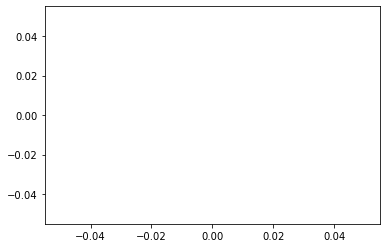

In [71]:
plt.plot(loss_all)

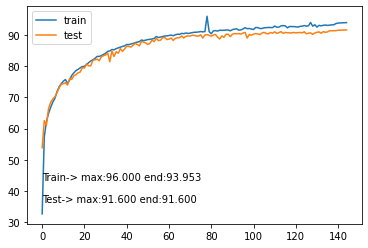

In [72]:
plt.plot(accs_all, label="train")
plt.plot(accs_test, label="test")
ymin, ymax = plt.gca().get_ylim()
plt.text(0, 0.8*ymin+0.2*ymax, f"Train-> max:{max(accs_all):.3f} end:{accs_all[-1]:.3f}")
plt.text(0, 0.9*ymin+0.1*ymax, f"Test-> max:{max(accs_test):.3f} end:{accs_test[-1]:.3f}")
                    
plt.legend()
plt.savefig("files/03_noisynas_v0_softmax_9.png")

In [73]:
max(accs_test)

91.60000000000001

In [74]:
max(accs_all)

96.0

In [75]:
np.argmax(accs_test)

144

In [76]:
len(accs_test)

145

In [77]:
dynet.non_linearity.bias

Parameter containing:
tensor([ 0.1679,  0.0724, -0.5550,  0.0567,  0.2950,  0.0881, -0.0326,  0.1185,
        -0.3093, -0.0916], device='cuda:0', requires_grad=True)